Yaml Loaders - utils.py


In [1]:
import glob
import os
import sys
from copy import deepcopy

import yaml
from yaml import dump

import yamlordereddictloader


class accelergy_loader(yaml.SafeLoader):
    """
    Accelergy yaml loader
    """

    def __init__(self, stream):

        self._root = os.path.split(stream.name)[0]
        super(accelergy_loader, self).__init__(stream)

def include_constructor(self, node):
    """
    constructor:
    parses the !include relative_file_path
    loads the file from relative_file_path and insert the values into the original file
    """
    filepath = self.construct_scalar(node)
    if filepath[-1] == ",":
        filepath = filepath[:-1]
    filename = os.path.join(self._root, filepath)
    with open(filename, "r") as f:
        return yaml.load(f, accelergy_loader)


def includedir_constructor(self, node):
    """
    constructor:
    parses the !includedir relative_file_path
    loads the file from relative_file_path and insert the values into the original file
    """
    filepath = self.construct_scalar(node)
    if filepath[-1] == ",":
        filepath = filepath[:-1]
    dirname = os.path.join(self._root, filepath)
    yamllist = []
    for filename in glob.glob(dirname + "/*.yaml"):
        with open(filename, "r") as f:
            yamllist.append(yaml.load(f, accelergy_loader))
    return yamllist
    
    
yaml.add_constructor("!include", include_constructor, accelergy_loader)
yaml.add_constructor("!includedir", includedir_constructor, accelergy_loader)

Currently I have to write the yaml files for constraints and run the schedulings and write equations of the memory handlers. 

In [11]:
class accelergy_dumper(yamlordereddictloader.SafeDumper):
    """ Accelergy yaml dumper """

    def ignore_aliases(self, _data):
        return True


def create_folder(directory):
    """
    Checks the existence of a directory, if does not exist, create a new one
    :param directory: path to directory under concern
    :return: None
    """
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("ERROR: Creating directory. " + directory)
        sys.exit()


def merge_dicts(dict1, dict2):
    merge_dict = deepcopy(dict1)
    merge_dict.update(dict2)
    return merge_dict


def write_yaml_file(filepath, content):
    """
    if file exists at filepath, overwite the file, if not, create a new file
    :param filepath: string that specifies the destination file path
    :param content: yaml string that needs to be written to the destination file
    :return: None
    """
    if os.path.exists(filepath):
        os.remove(filepath)
    create_folder(os.path.dirname(filepath))
    out_file = open(filepath, "a")
    out_file.write(dump(content, default_flow_style=False, Dumper=accelergy_dumper))


def get_yaml_format(content):
    return dump(content, default_flow_style=False, Dumper=accelergy_dumper)


def write_file(filepath, content):
    if os.path.exists(filepath):
        os.remove(filepath)
    create_folder(os.path.dirname(filepath))
    out_file = open(filepath, "a")
    out_file.write(content)


def remove_quotes(filepath):
    """
    :param filepath: file that needs to processed
    :return: None
    removes the quotes inside yaml files
    """
    if os.path.exists(filepath):
        new_content = ""
        f = open(filepath, "r")

        for line in f:
            if "'" in line:
                line = line.replace("'", "")
                new_content += line
        f.close()
        os.remove(filepath)
        newf = open(filepath, "w")
        newf.write(new_content)
        newf.close()


def ERROR_CLEAN_EXIT(*argv):
    msg_str = "ERROR: "
    for arg in argv:
        if type(arg) is not str:
            print(msg_str)
            print(arg)
            msg_str = ""
        else:
            msg_str += arg + " "
    print(msg_str)
    sys.exit(1)


def WARN(*argv):
    msg_str = "Warn: "
    for arg in argv:
        if type(arg) is not str:
            print(msg_str)
            print(arg)
            msg_str = ""
        else:
            msg_str += arg + " "
    print(msg_str)


def INFO(*argv):
    msg_str = "Info: "
    for arg in argv:
        if type(arg) is not str:
            print(msg_str)
            print(arg)
            msg_str = ""
        else:
            msg_str += arg + " "
    print(msg_str)


def ASSERT_MSG(expression, msg):
    if not expression:
        ERROR_CLEAN_EXIT(msg)


def add_functions_as_methods(functions):
    def decorator(Class):
        for function in functions:
            setattr(Class, function.__name__, function)
        return Class

    return decorator


def register_function(sequence, function):
    sequence.append(function)
    return function


def remove_brackets(name):
    """Removes the brackets from a component name in a list"""
    if "[" not in name and "]" not in name:
        return name
    if "[" in name and "]" in name:
        start_idx = name.find("[")
        end_idx = name.find("]")
        name = name[:start_idx] + name[end_idx + 1 :]
        name = remove_brackets(name)
        return name

Systemstate.py

In [13]:
class SystemState():
    def __init__(self):
        self.cc_classes = {}
        self.pc_classes = {}
        self.arch_spec = None
        self.hier_arch_spec = None
        self.ccs = {}
        self.pcs = {}
        self.action_counts = None
        self.plug_ins = []
        self.ERT = None
        self.ART = None
        self.parser_version = None
        self.flags = {}
        self.energy_estimations = None

    def set_flag_s(self, flag_name_val_dict):
        self.flags.update(flag_name_val_dict)

    def set_accelergy_version(self, version):
        self.parser_version = version

    def set_hier_arch_spec(self, arch_dict):
        ASSERT_MSG(self.hier_arch_spec is None, 'interpreted input arch is set')
        self.hier_arch_spec = arch_dict

    def set_arch_spec(self, arch_spec):
        ASSERT_MSG(self.arch_spec is None, 'architecture spec is already set')
        self.arch_spec = arch_spec

    def add_cc_class(self, cc_class):
        cc_class_name = cc_class.get_name()
        ASSERT_MSG(cc_class_name not in self.cc_classes, '%s compound class is already added'%(cc_class_name))
        self.cc_classes[cc_class_name] = cc_class

    def add_pc_class(self, pc_class):
        pc_class_name = pc_class.get_name()
        ASSERT_MSG(pc_class_name not in self.pc_classes, '%s primitive class is already added'%(pc_class_name))
        self.pc_classes[pc_class_name] = pc_class

    def add_cc(self, cc):
        cc_name = cc.get_name()
        ASSERT_MSG(cc_name not in self.ccs, '%s compound component is already added'%(cc_name))
        self.ccs[cc_name] = cc

    def add_pc(self, pc):
        pc_name = pc.get_name()
        ASSERT_MSG(pc_name not in self.ccs, '%s compound component is already added'%(pc_name))
        self.pcs[pc_name] = pc

    def add_plug_ins(self, plug_ins):
        ASSERT_MSG(type(plug_ins) is list, 'plug in objects need to be passed in as a list')
        self.plug_ins = plug_ins

    def set_ERT(self, ERT):
        self.ERT = ERT

    def set_ART(self, ART):
        self.ART = ART

    def set_action_counts(self, action_counts):
        self.action_counts = action_counts

    def set_energy_estimations(self, energy_estimations):
        self.energy_estimations = energy_estimations

action.py

In [14]:
from copy import deepcopy


class Action(object):
    """Action class"""
    def __init__(self, action_def_dict):

        self.action_def_dict = action_def_dict
        self.name = action_def_dict['name']

        self._arguments = None
        self.set_arguments(action_def_dict)

        # compound action contains action definitions in terms of subcomponents
        self._subcomponents = None
        self.set_subcomponents(action_def_dict)

        # repeat has the same meaning as action share
        if 'repeat' in action_def_dict:
            self._action_share = action_def_dict['repeat']
        elif 'action_share' in action_def_dict:
            self._action_share = action_def_dict['action_share']
        else:
            self._action_share = None
        # only compound actions will later set this property
        self._primitive_list = None

    def set_arguments(self, action_def_dict):
        if 'arguments' in action_def_dict:
            self._arguments = {}
            for arg_name, arg_range in action_def_dict['arguments'].items():
                self._arguments[arg_name] = arg_range

    def set_subcomponents(self, action_def_dict):
        if 'subcomponents' in action_def_dict:
            self._subcomponents = {}
            for subcomp in action_def_dict['subcomponents']:
                subcompActions = []
                for subcompAction in subcomp['actions']:
                    subcompActions.append(Action(subcompAction))
                self._subcomponents[subcomp['name']] = subcompActions

    def set_primitive_list(self, primitive_list):
        self._primitive_list = primitive_list

    def set_action_share(self, new_action_share):
        """update the parsed repeat/action_share value"""
        self._action_share = new_action_share

    def set_argument(self, new_arg_dict):
        """ update one or more argument name-val pairs"""
        self._arguments.update(new_arg_dict)

    def set_subcomps(self, defined_subcomps):
        self._subcomponents = defined_subcomps

    def get_name(self):
        return self.name

    def get_action_share(self):
        return self._action_share

    def get_arguments(self):
        return self._arguments

    def get_argument(self, arg_name):
        return self._arguments[arg_name]

    def get_subcomps(self):
        ASSERT_MSG(self._subcomponents is not None, 'action does not have defined subcomponents')
        return self._subcomponents

    def get_primitive_list(self):
        return self._primitive_list

    def get_action_info_as_dict(self):
        action_dict = {'name': self.name}
        if self._subcomponents is not None: action_dict['subcomponents'] = self._subcomponents
        if self._arguments is not None: action_dict['arguments'] = self._arguments
        return action_dict

    def get_subactions(self, subcompName):
        ASSERT_MSG(self._subcomponents is not None and subcompName in self._subcomponents,
                   'cannot find subactions associated with %s for action %s'%(subcompName, self.name))
        return self._subcomponents[subcompName]

    def get_arg_val(self, argName):
        ASSERT_MSG(argName in self._arguments, 'argument name %s is not associated with action %s'%(argName, self.name))
        return self._arguments[argName]

    def set_arg(self, arg_dict):
        self._arguments.update(arg_dict)

    def flatten_action_args_into_list(self, mappingDict):
        """ flatten an action into a list representing all possible argument value combinations"""

        args = self.get_arguments()
        if args is None:
            return [self]  # no arguments, no need to flatten

        # an action needs to be flattened into a list of actions with the same action name but different arg vals
        total_entries = 1
        argument_range_record = {}
        for arg_name, arg_range in args.items():
            ASSERT_MSG(type(arg_range) is str, '%s: argument value for action %s is not string, cannot parse range'%(arg_name,self.name))
            ASSERT_MSG('..' in arg_range, '%s: argument value for action %s is not range, cannot parse range'%(arg_name,self.name))
            new_arg_range = Action.map_arg_range_bounds(arg_range, mappingDict)[0]
            startIdx, endIdx = Action.parse_arg_range(new_arg_range)
            total_entries *= (endIdx - startIdx + 1)
            argument_range_record[arg_name] = (startIdx, endIdx)

        action_list = []
        for entry_idx in range(total_entries):
            offset = 1
            arg_def = {}
            for arg_name, range_record in argument_range_record.items():
                arg_range = range_record[1] - range_record[0] + 1
                arg_def[arg_name] = (entry_idx // offset) % arg_range + range_record[0]
                offset *= arg_range
            subcomp_list = []
            new_action = deepcopy(self); new_action._arguments = arg_def
            action_list.append(new_action)
        return action_list

    @staticmethod
    def parse_arg_range(arg_range):
        """ Parse the start index and end index for an argument range"""
        if type(arg_range) is not str or '..' not in arg_range:
            ERROR_CLEAN_EXIT('cannot parse the argument range specification: ', arg_range)
        split_sub_string = arg_range.split('..')
        start_idx = int(split_sub_string[0])
        end_idx = int(split_sub_string[1])
        return start_idx, end_idx

    @staticmethod
    def expand_action_to_list_with_arg_values(action_info):
        """flatten actions with arguments into list
           1) input action is fully defined with numerical ranges
           2) output list contains a list of actions each with a possible set of argument values
        """

        action_name = action_info['name']
        total_entries = 1
        argument_range_record = {}
        for argument_name, argument_range in action_info['arguments'].items():
            start_idx, end_idx = Action.parse_arg_range(argument_range)
            total_entries *= (end_idx - start_idx + 1)
            argument_range_record[argument_name] = (start_idx, end_idx)
        expanded_list = [{'name': action_name, 'arguments':{}} for i in range(total_entries)]
        # construct list of dictionaries that contain all the possible combination of argument values
        for entry_idx in range(total_entries):
            offset = 1
            for argument_name, range_record in argument_range_record.items():
                arg_range = range_record[1] - range_record[0] + 1
                expanded_list[entry_idx]['arguments'][argument_name] = \
                    (entry_idx // offset) % arg_range + range_record[0]
                offset *= arg_range
        return expanded_list

    @staticmethod
    def map_arg_range_bounds(arg_range_str, attributes_dict):
        """
        arguments for actions might have ranges that are specified in terms of it attributes
        parses the argument ranges in the format int/str..int/str, where str can be arithmetic operation

        :param arg_range_str: string that decribes the range of a compound action
        :param attributes_dict: attribute name-value pairs of the compound component
        :return: parsed argument range, whether there was binding
        """
        split_sub_string = arg_range_str.split('..')
        detect_arg_range_binding = False
        # process the start index
        try:
            start_idx = int(split_sub_string[0])
        except ValueError:
            op_type, op1, op2 = parse_expression_for_arithmetic(split_sub_string[0], attributes_dict)
            if op_type is not None:
                start_idx = process_arithmetic(op1, op2, op_type)
            else:
                if split_sub_string[0] not in attributes_dict:
                    ERROR_CLEAN_EXIT('cannot find mapping from', arg_range_str, 'to', attributes_dict)
                start_idx = attributes_dict[split_sub_string[0]]
            detect_arg_range_binding = True

        # process the end index
        try:
            end_idx = int(split_sub_string[1])
        except ValueError:
            op_type, op1, op2 = parse_expression_for_arithmetic(split_sub_string[1], attributes_dict)
            if op_type is not None:
                end_idx = process_arithmetic(op1, op2, op_type)
            else:
                if split_sub_string[1] not in attributes_dict:
                    ERROR_CLEAN_EXIT('cannot find mapping from', arg_range_str, 'to', attributes_dict)
                end_idx = attributes_dict[split_sub_string[1]]
            detect_arg_range_binding = True

        new_arg_range_str = str(start_idx) + '..' + str(end_idx)

        return new_arg_range_str, detect_arg_range_binding

    @staticmethod
    def parse_arg_range(arg_range):
        if type(arg_range) is not str or '..' not in arg_range:
            ERROR_CLEAN_EXIT('cannot parse the argument range specification: ', arg_range)
        split_sub_string = arg_range.split('..')
        start_idx = int(split_sub_string[0])
        end_idx   = int(split_sub_string[1])
        return start_idx, end_idx

subcomponent.py

In [15]:
class Subcomponent:
    def __init__(self, comp_def):
        self.dict_reprsentation = comp_def
        if 'attributes' not in self.dict_reprsentation:
            self.dict_reprsentation['attributes'] = {}

    def set_name(self, name):
        self.dict_reprsentation['name'] = name

    def get_name(self):
        return self.dict_reprsentation['name']

    def get_class_name(self):
        return self.dict_reprsentation['class']

    def get_attributes(self):
        return self.dict_reprsentation['attributes']


    def get_area_share(self):
        return self.dict_reprsentation['area_share']

    def add_new_attr(self, attr_dict):
        self.dict_reprsentation['attributes'].update(attr_dict)

    def set_area_share(self, area_share):
        self.dict_reprsentation['area_share'] = area_share

componenclass.py

In [16]:
from copy import deepcopy
from collections import OrderedDict

class ComponentClass:
    def __init__(self, class_dict):
        self._name = class_dict['name']
        self._default_attributes = deepcopy(class_dict['attributes'])

        self._actions = {}
        self.set_actions(class_dict['actions'])

        self._subcomponents = None
        if 'subcomponents' in class_dict:
            self._subcomponents = {}
            self.type = 'compound'
            for scomp in class_dict['subcomponents']: self._subcomponents[scomp['name']] = Subcomponent(scomp)
        else:
            self.type = 'primitive'
        self._primitive_type = class_dict['primitive_type'] if 'primitive_type' in class_dict else None

    def set_actions(self, action_list):
        ASSERT_MSG(type(action_list) is list,
                   '%s class description must specify its actions in list format'%(self.get_name()))
        for action in action_list:
            ASSERT_MSG('name' in action, '%s class actions must contain "name" keys'%(self.get_name()))
            self._actions[action['name']] = Action(action)

    #-----------------------------------------------------
    # Getters
    #-----------------------------------------------------
    def get_name(self):
        return self._name

    def get_default_attr_to_apply(self, obj_attr_name_list):
        attr_to_be_applied = OrderedDict()
        for attr_name, attr_val in self._get_default_attrs().items():
            if attr_val == "must_specify":
                ASSERT_MSG(attr_name in obj_attr_name_list,
                           "attributes %s for compound class %s must be specified in architecture description"
                           %(attr_name, self.get_name()))
            if attr_name not in obj_attr_name_list:
                attr_to_be_applied[attr_name] = attr_val
        return attr_to_be_applied

    def _get_default_attrs(self):
        return self._default_attributes

    def _get_attr_name_list(self):
        return list(self._default_attributes.keys())

    def _get_attr_default_val(self, attrName):
        ASSERT_MSG(attrName in self._default_attributes, 'Attribute %s cannot be found in class %s'%(attrName, self.get_name()))
        return self._default_attributes[attrName]

    def get_action_name_list(self):
        return list(self._actions.keys())

    def get_action(self, actionName):
        ASSERT_MSG(actionName in self._actions, '%s does not exist in class %s'%(actionName, self.get_name()))
        return self._actions[actionName]

    def get_subcomponents_as_dict(self):
        ASSERT_MSG(self._subcomponents is not None, 'component class %s does not have subcomponents' % self.get_name())
        return self._subcomponents

    def get_primitive_type(self):
        return self._primitive_type


In [4]:
import glob
import os
import sys
from copy import deepcopy

import yaml
from yaml import dump

import yamlordereddictloader


class constraintyaml_loader(yaml.SafeLoader):
    """
    Constraints yaml loader
    """

    def __init__(self, stream):

        self._root = os.path.split(stream.name)[0]
        super(constraintyaml_loader, self).__init__(stream)

def include_constructor(self, node):
    """
    constructor:
    parses the !include relative_file_path
    loads the file from relative_file_path and insert the values into the original file
    """
    filepath = self.construct_scalar(node)
    if filepath[-1] == ",":
        filepath = filepath[:-1]
    filename = os.path.join(self._root, filepath)
    with open(filename, "r") as f:
        return yaml.load(f, constraintyaml_loader)
yaml.add_constructor("!include", include_constructor, constraintyaml_loader)


Integrations.py

action_counts:
  local:
  - action_counts:
    - counts: 31306
      name: idle
    - arguments:
        address_delta: 2
        data_delta: 1
      counts: 1152
      name: fill
    - arguments:
        address_delta: 0
        data_delta: 0
      counts: 1150
      name: read
    - arguments:
        address_delta: 2
        data_delta: 1
      counts: 2
      name: read
    name: eyeriss_like.weights_glb


  subtree:
    - name: eyeriss_like
      attributes:
        technology: 40nm
      local:
        - name: weights_glb
          class: smartbuffer_SRAM
          attributes:
            memory_width: 64
            memory_depth: 1024
            n_banks: 2
        - name: shared_glb
          class: smartbuffer_SRAM
          attributes:
            memory_width: 64
            n_banks: 25
            bank_depth: 512
            memory_depth: bank_depth * n_banks
            n_buffets: 2
            update_fifo_depth: 2
        - name: ifmap_NoC
          class: XY_NoC
          attributes:
            datawidth: 16
            col_id_width: 5
        - name: weights_NoC
          class: XY_NoC
          attributes:
            datawidth: 64
        - name: psum_write_NoC
          class: XY_NoC
          attributes:
            datawidth: 64
        - name: psum_read_NoC
          class: XY_NoC
          attributes:
            datawidth: 64
            Y_X_wire_avg_length: 4mm
      subtree:
      - name: PE[0..167]
        attributes:
          memory_width: 16
        local:
          - name: ifmap_spad
            class: smartbuffer_RF
            attributes:
              memory_depth: 12
              buffet_manager_depth: 0
          - name: weights_spad
            class: smartbuffer_SRAM
            attributes:
              memory_depth: 224
              buffet_manager_depth: 0
          - name: psum_spad
            class: smartbuffer_RF
            attributes:
              memory_depth: 24
              buffet_manager_depth: 24
              update_fifo_depth: 2
          - name: mac
            class: intmac
            attributes:
              datawidth: 16

hardware_primitives.py

Multipliers 

---

Sytolic Array (of Standard Sizes)

---
SRAM Arrays of Some Standard Sizes (A dictionary with different Bank Depth and Number of Banks)

---

ORION NOC (XY_NOC)

---


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

def model(x, p):
    return x ** (2 * p + 1) / (1 + x ** (2 * p))

with plt.style.context(['science','no-latex']):
    x = np.linspace(0.75, 1.25, 201)
    fig, ax = plt.subplots()
    for p in [10, 15, 20, 30, 50, 100]:
        ax.plot(x, model(x, p), label=p)
    ax.legend(title='Order')
    ax.set(xlabel='Voltage (mV)')
    #     ax.set(ylabel='Current ($\mu$A)')
    ax.autoscale(tight=True)
    plt.show()
#     fig.savefig('figures/fig1.pdf')
#     fig.savefig('figures/fig1.jpg', dpi=300)

# with plt.style.context(['science', 'ieee']):
#     x = np.linspace(0.75, 1.25, 201)
#     fig, ax = plt.subplots()
#     for p in [10, 20, 50]:
#         ax.plot(x, model(x, p), label=p)
#     ax.legend(title='Order')
#     ax.set(xlabel='Voltage (mV)')
#     ax.set(ylabel='Current ($\mu$A)')
#     ax.autoscale(tight=True)
# #     fig.savefig('figures/fig2.pdf')
# #     fig.savefig('figures/fig2.jpg', dpi=300)



with plt.style.context(['science', 'high-vis','no-latex']):
    x = np.linspace(0.75, 1.25, 201)
    fig, ax = plt.subplots()
    for p in [10, 15, 20, 30, 50, 100]:
        ax.plot(x, model(x, p), label=p)
    ax.legend(title='Order')
    ax.set(xlabel='Voltage (mV)')
#     ax.set(ylabel='Current ($\mu$A)')
    ax.autoscale(tight=True)
    plt.show()
#     fig.savefig('figures/fig4.pdf')
#     fig.savefig('figures/fig4.jpg', dpi=300)

with plt.style.context(['dark_background', 'high-vis']):
    x = np.linspace(0.75, 1.25, 201)
    fig, ax = plt.subplots()
    for p in [10, 15, 20, 30, 50, 100]:
        ax.plot(x, model(x, p), label=p)
    ax.legend(title='Order')
    ax.set(xlabel='Voltage (mV)')
#     ax.set(ylabel='Current ($\mu$A)')
    ax.autoscale(tight=True)
    plt.show()
# #     fig.savefig('figures/fig5.pdf')
# #     fig.savefig('figures/fig5.jpg', dpi=300)

# # Plot different color cycles 

with plt.style.context(['science', 'bright','no-latex']):
    x = np.linspace(0.75, 1.25, 201)
    fig, ax = plt.subplots()
    for p in [5, 10, 15, 20, 30, 50, 100]:
        ax.plot(x, model(x, p), label=p)
    ax.legend(title='Order')
    ax.set(xlabel='Voltage (mV)')
#     ax.set(ylabel='Current ($\mu$A)')
    ax.autoscale(tight=True)
#     fig.savefig('figures/fig6.pdf')
#     fig.savefig('figures/fig6.jpg', dpi=300)

with plt.style.context(['science', 'vibrant','no-latex']):
    x = np.linspace(0.75, 1.25, 201)
    fig, ax = plt.subplots()
    for p in [5, 10, 15, 20, 30, 50, 100]:
        ax.plot(x, model(x, p), label=p)
    ax.legend(title='Order')
    ax.set(xlabel='Voltage (mV)')
#     ax.set(ylabel='Current ($\mu$A)')
    ax.autoscale(tight=True)
#     fig.savefig('figures/fig7.pdf')
#     fig.savefig('figures/fig7.jpg', dpi=300)

with plt.style.context(['science', 'muted','no-latex']):
    x = np.linspace(0.75, 1.25, 201)
    fig, ax = plt.subplots()
    for p in [5, 7, 10, 15, 20, 30, 38, 50, 100, 500]:
        ax.plot(x, model(x, p), label=p)
    ax.legend(title='Order', fontsize=7)
    ax.set(xlabel='Voltage (mV)')
#     ax.set(ylabel='Current ($\mu$A)')
    ax.autoscale(tight=True)
#     fig.savefig('figures/fig8.pdf')
# #     fig.savefig('figures/fig8.jpg', dpi=300)

In [3]:
a = np.random.randn(20,20,3)

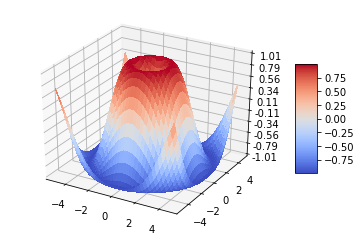

In [5]:
                    
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()       
                    
                    

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#

n_groups = 15
rects1 = ax.bar(index+bar_width,read_dram, bar_width, color='blue', error_kw=error_config,label='DRAM')
rects2 = ax.bar(index + 2.2*bar_width,read_nvm, bar_width, color='green', error_kw=error_config,label='NVM')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Average Read Size \n (in KB)',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
fig.tight_layout()
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('read_avg.png', bbox_inches = 'tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False?
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

n_groups = 15
fig, ax = plt.subplots(figsize=(30,6))
index = np.arange(n_groups)
print(index)
bar_width = 0.05
ax.set_yscale('linear')
# opacity = 0.4
error_config = {'ecolor': '0.3'}
index = np.arange(n_groups)
# print(index)
bar_width = 0.1
# ax.set_yscale('log')
opacity = 0.1
error_config = {'ecolor': '0.3'}
#


rects1 = ax.bar(index+bar_width,h0_writes[:,0], bar_width, color='red', error_kw=error_config,label='DRAM')+ax.bar(index+bar_width, h0_writes[:,1], bar_width, bottom=h0_writes[:,0], color='gold', error_kw=error_config,label='NVM')+ax.bar(index+bar_width, h0_writes[:,2], bar_width,bottom=h0_writes[:,0]+h0_writes[:,1],color='aqua', error_kw=error_config,label='Misses')
rects1 = ax.bar(index+bar_width, h0_writes[:,0]+h0_writes[:,1]+h0_writes[:,2], bar_width, color='none', error_kw=error_config,label='h=2',hatch='o')
rects2 = axpgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
matplotlib.rcParams.update(pgf_with_rc_fonts).bar(index + 2.2*bar_width,h1_writes[:,0]  , bar_width, color='red', error_kw=error_config)+ax.bar(index + 2.2*bar_width, h1_writes[:,1] , bar_width,bottom=h1_writes[:,0], color='gold', error_kw=error_config)+ax.bar(index+2.2*bar_width,h1_writes[:,2] , bar_width,bottom=h1_writes[:,0]+h1_writes[:,1],color='aqua', error_kw=error_config)
rects2 = ax.bar(index + 2.2*bar_width, h1_writes[:,0]+h1_writes[:,1]+h1_writes[:,2], bar_width, color='none',hatch='x', error_kw=error_config,label='h=1')
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0] , bar_width, color='red',hatch='/',error_kw=error_config)+ax.bar(index + 3.4*bar_width, h2_writes[:,1] , bar_width, bottom=h2_writes[:,0], color='gold',hatch='/',error_kw=error_config)+ax.bar(index+3.4*bar_width, h2_writes[:,2], bar_width,bottom= h2_writes[:,0]+h2_writes[:,1],color='aqua', error_kw=error_config)
rects3 = ax.bar(index + 3.4*bar_width, h2_writes[:,0]+h2_writes[:,1]+h2_writes[:,2], bar_width, color='none',hatch='/',error_kw=error_config,label='h=0')

# ax.set_ylabel('SpeedUp (GraphMat=1)',fontsize=14,fontweight='bold')
ax.set_xticks(index + bar_width*2)
ax.set_xticklabels(('<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>','<1,.256,4>', '<2,.128,2>', '<5,.05,0.8>','<10,.025,0.4>','<20,.012,0.2>'))
ax.set_ylabel('Fraction of Number of Writes  \n in DRAM/NVM',fontsize=20,fontweight='bold')
ax.set_xlabel('Zipf\'s Parameter =0.9,                                                         Zipf\'s Parameter =0.8,                                                                                        Zipf\'s Parameter =0.7',fontsize=20,fontweight='bold')
ax.legend(fontsize=20)
# ax.set_ylim( (pow(10,-2),pow(10,3)))
fig.tight_layout()
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.savefig('data_writes.png', bbox_inches = 'tight')
plt.show()

architecture:
# ============================================================
# Architecture Description
# ============================================================
  version: 0.3
  subtree:
    - name: simple              # top-level name key has the value as your design name, there can be only one component is the top level list, which is the design
      attributes:               # shared attributes for all subcomponents in design
        technology: 65nm
        voltage: 1
        num_glbs: 5
      local:                     # list of nodes under design, this design only has one node
        - name: glb[0..num_glbs-1]
          class: shared_SRAM      # use the primitive component type specification of the compound component class
          attributes:            # hardware attributes that are different from default values
            nbanks: 1
            bank_depth: 224
            bank_width: 16
            n_rd_ports: 2        # number of architectural read ports (same as default value, can be omitted)
            n_wr_ports: 2        # number of architectural write ports (same as default value, can be omitted)
            n_bank_rd_ports: 1   # (same as default value, can be omitted)
            n_bank_wr_ports: 1   # (same as default value, can be omitted)
            n_bank_rdwr_ports: n_bank_rd_ports + n_bank_wr_ports


In [57]:
from collections import OrderedDict

data = OrderedDict([
    ('key1', 'val1'),
    ('key2', OrderedDict([('key21', 'val21'), ('key22', 'val22')]))
])
yaml.dump(
    data,
    open('myfile.yml', 'w'),
    Dumper=yamlordereddictloader.Dumper,
    default_flow_style=False)

components:

  design.GLB:

    name: design.GLB
    class: SRAM
    attributes:
      technology: 65nm
      n_PEs: 3
      word_width: 16
      n_words: 4
      width: 64
      depth: 2560
      nbanks: 5
      n_rd_ports: 0
      n_wr_ports: 0
      n_rdwr_ports: 1
      latency: 5ns
      design.PE[0..2].byte_sp:
    name: design.PE[0..2].byte_sp
        class: regfile
        attributes:
          technology: 65nm
          n_PEs: 3
          width: 8
          depth: 12
          datawidth: 8
          latency: 5ns
      design.PE[0..2].mac[0..1]:
        name: design.PE[0..2].mac[0..1]
        class: intmac
        attributes:
          technology: 65nm
          n_PEs: 3
          datawidth: 8
          num_pipeline_stages: 2
          latency: 5ns
      design.PE[0..2].arithmetic_units.adder:
        name: design.PE[0..2].arithmetic_units.adder
        class: intadder
        attributes:
          technology: 65nm
          n_PEs: 3
          datawidth: 8
          num_pipeline_stages: 1
          latency: 5ns
      design.PE[0..2].arithmetic_units.mac[0..1]:
        name: design.PE[0..2].arithmetic_units.mac[0..1]
        class: intmac
        attributes:
          technology: 65nm
          n_PEs: 3
          datawidth: 8
          num_pipeline_stages: 2
          latency: 5ns


  - name: diannao
      attributes:
        technology: 40nm

      local:
        - name       : DRAM
          class      : DRAM
          attributes :
            instances       : 1
            word-bits       : 16
        
        - name       : OutputBuffer
          class      : SRAM
          attributes :
            entries         : 1024  # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        - name       : InputBuffer
          class      : SRAM
          attributes :
            entries         : 1024 # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        - name       : PsumRegFile
          class      : regfile
          attributes :
            entries         : 1
            instances       : 16
            meshX           : 16
            word-bits       : 16
            cluster-size    : 16
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
            
        - name       : WeightBuffer
          class      : regfile
          attributes :
            entries         : 64
            instances       : 256
            meshX           : 16
            word-bits       : 16
            cluster-size    : 256
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle

        - name       : MACs
          class      : intmac
          attributes :            
            instances       : 256
            meshX           : 16
            word-bits       : 16

# Source Code 

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import glob
import os
import sys
from collections import deque
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import yaml
import yamlordereddictloader
from torchvision import models
from yaml import dump

from ir.handlers import handlers
from ir.trace import trace

from utils.logger import create_logger

In [3]:
# Just preload the graph for fast experiments 
# Create Graph

for name, model in models.__dict__.items():
#     print(name)
    if not name.islower() or name.startswith("__") or not callable(model):
        continue
    if "vgg11" in name and "vgg11_bn" not in name :
        model = model().eval()
        inputs = torch.randn(1, 3, 299, 299)
        vgg11_graph = trace(model, inputs)
#         print(vgg11_graph)
    if "resnet50" in name:
        model = model().eval()
        inputs = torch.randn(1, 3, 100, 100)
        graph = trace(model, inputs)

In [8]:
from generator import Generator
from utils.visualizer import bar_graph


In [9]:
import collections
import pdb

import numpy as np
import yaml
import yamlordereddictloader

from utils.logger import create_logger


class Scheduling:
    def __init__(self, hwfile="default.yaml"):
        base_dir = "configs/"
        self.total_cycles = 0
        self.logger = create_logger("logs/stats.txt")
        self.config = self.create_config(
            yaml.load(open(base_dir + hwfile), Loader=yamlordereddictloader.Loader)
        )


In [10]:
def create_config(self, hwdict):
    config = hwdict["architecture"]

    self.logger.info("Config Statistics : ")

    self.mle = config["memory_levels"]

    self.read_accesses = np.zeros((self.mle))
    self.write_accesses = np.zeros((self.mle))
    self.mem_size = np.zeros((self.mle))
    self.mem_util = np.zeros((self.mle))
    self.mem_free = np.zeros((self.mle))
    self.mem_read_bw = np.zeros((self.mle))
    self.mem_write_bw = np.zeros((self.mle))

    mm_compute = config["mm_compute"]
    vector_compute = config["vector_compute"]

    if config["mm_compute"]["class"] == "systolic_array":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"]) ** 2) * mm_compute["N_PE"] / 2
        )
        config["comp_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

        self.logger.info(
            "MM Compute per cycle : %d", config["mm_compute_per_cycle"]
        )
        self.logger.info("Compute Bandwidth Required : %d", config["comp_bw"])

    if config["mm_compute"]["class"] == "mac":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"]) ** 2) * mm_compute["N_PE"] / 2
        )
        config["comp_read_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

    for i in range(self.mle):
        memory = config["memory"]["level" + str(i)]
        self.mem_read_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["read_ports"]
            * memory["width"]
        )
        self.mem_write_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["write_ports"]
            * memory["width"]
        )
        self.mem_size[i] = memory["size"]

        self.logger.info(
            "Memory at Level %d, Read Bandwidth %d Write Bandwidth %d",
            i,
            self.mem_read_bw[i],
            self.mem_write_bw[i],
        )

    return config

In [11]:
def run(self, graph):

    """
     Check both size, utilization and bandwidths at every node
     What about memory size that can also get exhausted ?
     So if memory size is exhausted, then have to go to a previous level and write there ?
     if any level utilization is exhausted then only the immediate memory required will be kept.
     if the memory is empty in size, but is not bandwidth, it is useless?
     Cannot do prefetching
     Read access of the next node will decrease
     Bandwidth is available but size is not?, can do prefetching, but now the memory fetches have to check, 
     whether to do fetches of the same node or a different node
     Say bandwidth at level0 is sufficient, at level1 is insufficient, then at level1 we have a bottlenecks
     slower so it will take its own time
     Do vector operations in the meantime perhaps ? 

    """

    config = self.config

    read_bw_req = []
    write_bw_req = []
    read_bw_actual = []
    write_bw_actual = []
    cycles = []
    transferable_checkpointed_edge = []
    all_checkpointed_edge = []
    # Mem Fetch time of the last Nodes
    print(self.mem_free[0], self.mem_util[0], self.mem_size[0])
    bandwidth_idle_time = 0
    compute_idle_time = 0
    mem_size_idle_time = 0
    mem_free = True
    for n, node in enumerate(graph.nodes):

        # These are last level read/write accesses
        compute_expense, read_access, write_access = node.get_stats()

        self.logger.info(node.get_stats())
        self.mem_util[0] += node.in_edge_mem
        
        # Total Free memory
        for i in range(self.mle - 1):
            self.mem_free[i] = self.mem_size[i] - self.mem_util[i]
            
        print("2",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        time_compute = compute_expense / config["mm_compute_per_cycle"]
        read_bw_ll = read_access / (time_compute)
        write_bw_ll = write_access / (time_compute)
        step_cycles = time_compute
        read_bw_req.append(read_bw_ll)
        write_bw_req.append(write_bw_ll)
   
        print("bandwidth",read_bw_ll, write_bw_ll, step_cycles) 
        
        if self.mem_free[0] < node.mem_util:
            mem_free = False
            # node mem_util = output edge
            self.logger.info("Memory size is too low/ Memory is Full")
            self.logger.info("Node or Node memory Requirements too high")
            # Rearrange the checkpointed_nodes
            # rearrange = True

            # Is it possible now : Otherwise update the last level memory bandwidth requirements
            if(self.mem_free[0]<0):      
                step_cycles += (node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)*(
                   (self.mem_free[0]+node.in_edge_mem)  / self.mem_read_bw[self.mle - 1]
                )    
        else:
            self.mem_util[0] += node.mem_util
            self.mem_free[0] -= node.mem_util
        print("2.5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        
           
        assert(self.mem_free[0] < self.mem_size[0])
        # Last level memory fetch takes more time, so that may be a bottleneck
        bandwidth_available = read_bw_ll < self.mem_read_bw[self.mle - 1]

        # If Bandwidth is not available : Cannot Prefetch
        if (bandwidth_available) == False:
            step_cycles += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute

        # If memory is not free for the next node and Bandwidth is available : Move nodes back and forth
        # if(total_mem_free[0] == 0 and (bandwidth_available)):
        # for(nodes in checkpointed_nodes):
        # checkpointed but not immediate node

        # Check if memory is free and Bandwidth available : From the Data Dependence Graph, Prefetch new node

        # pdb.set_trace()
        if self.mem_free[0] > 0 and (bandwidth_available):
            print("Prefetching new nodes")
            if n < len(graph.nodes) - 1:
                if self.mem_free[0] > node.next.mem_util:
                    read_access += node.next.mem_util
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        self.mem_util[0] += node.next.mem_util
                        self.mem_free[0] -= node.next.mem_util
                        node.next.mem_util = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_util = read_access - read_bw_ll * step_cycles

                else:
                    read_access += self.mem_free[0]
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        node.next.mem_util = node.next.mem_util - self.mem_free[0]
                        self.mem_util[0] = self.mem_size[0]
                        self.mem_free[0] = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_util = read_access - read_bw_ll * step_cycles
        print("3",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        
            # TODO Consider Write bandwidth for a block read memory or Write Bandwidth  for a endurance purposes
        self.mem_util[0] -= node.in_edge_mem
        print("4",self.mem_free[0], self.mem_util[0], self.mem_size[0])
    
        if mem_free:
            self.mem_util[0] -= node.mem_util
        print("5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        
        self.logger.info(
            "Node operator %r, Step Cycles %d, Read Accesses %d, Write Accesses %d ",
            node.operator,
            step_cycles,
            read_access,
            write_access,
        )
        self.total_cycles += step_cycles
        cycles.append(step_cycles)
        read_bw_actual.append(read_access / step_cycles)
        write_bw_actual.append(write_access / step_cycles)
        print("actual",read_access / step_cycles, write_access / step_cycles, step_cycles) 
    return read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles

In [12]:
Scheduling.create_config = create_config
Scheduling.run = run

In [13]:
def runner(graph_set):
    """
    Runs the Input Graph
    """
    
    """
    Scheduling works in the following way :
    1. Start with a given/random Hardware point -> Nodes of the graph are scheduled (prefetching)
    
    2. Do the Scheduling with that Point -> Mapping stops here -> Further evaluation is done using accelergy 
    (with values taken from ERT/ART) -> If values not available -> Use plugins for generating these values 
    
    3. Log bottlenecks and work on a different Hardware point -> do this till some realistically
    max, min values are not violated -> Values/Analyses for a different/unavailable point will require full 
    From the technology node set, generate the reference tables using plugins integration of plugins -> 
    Currently using a table at 40nm.   
    
    4. Optimization metric (time/area/energy) of execution in various components, 
    then optimize the metric of execution and take decisions accordingly 
    
    5. Optimize over different workloads ?
    
    """
    
    num_iterations = 5
    generator = Generator()
    for graph in graph_set:
        scheduler = Scheduling()
        read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles = scheduler.run(graph)
        read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
        bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes, cycles)
        generator.save_statistics(scheduler)
        
        for i in range(num_iterations):
            nexthw = generator.findnext(scheduler)
            generator.writehwfile("iter" + str(i) + "hw.yaml")
            scheduler.create_config(newhw)
            read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles=scheduler.run(graph)
            read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
            bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes, cycles)
    

In [14]:
# Have to plot memory bandwidth utilization over time

0.0 0.0 50000000.0
2 49970000.0 30000.0 50000000.0
bandwidth 2675.7579755102042 0.0 179.443359375
2.5 49329853.0 670147.0 50000000.0
Prefetching new nodes
3 48661562.5 1338437.5 50000000.0
4 48661562.5 1308437.5 50000000.0
5 48661562.5 668290.5 50000000.0
actual 6400.0 0.0 179.443359375
2 49291709.5 708290.5 50000000.0
bandwidth 131073.6384 0.0 39.0625
2.5 48623419.0 1376581.0 50000000.0
3 48623419.0 1376581.0 50000000.0
4 48623419.0 1336581.0 50000000.0
5 48623419.0 668290.5 50000000.0
actual 6400.0 0.0 800.01
2 49251709.5 748290.5 50000000.0
bandwidth 14565.193955555556 0.0 703.125
2.5 38930557.5 11069442.5 50000000.0
3 38930557.5 11069442.5 50000000.0
4 38930557.5 10989442.5 50000000.0
5 38930557.5 668290.5 50000000.0
actual 6399.999999999999 0.0 1600.1800000000003
2 49251709.5 748290.5 50000000.0
bandwidth 131072.8192 0.0 156.25
2.5 28611581.5 21388418.5 50000000.0
3 28611581.5 21388418.5 50000000.0
4 28611581.5 21308418.5 50000000.0
5 28611581.5 668290.5 50000000.0
actual 6400.0 0

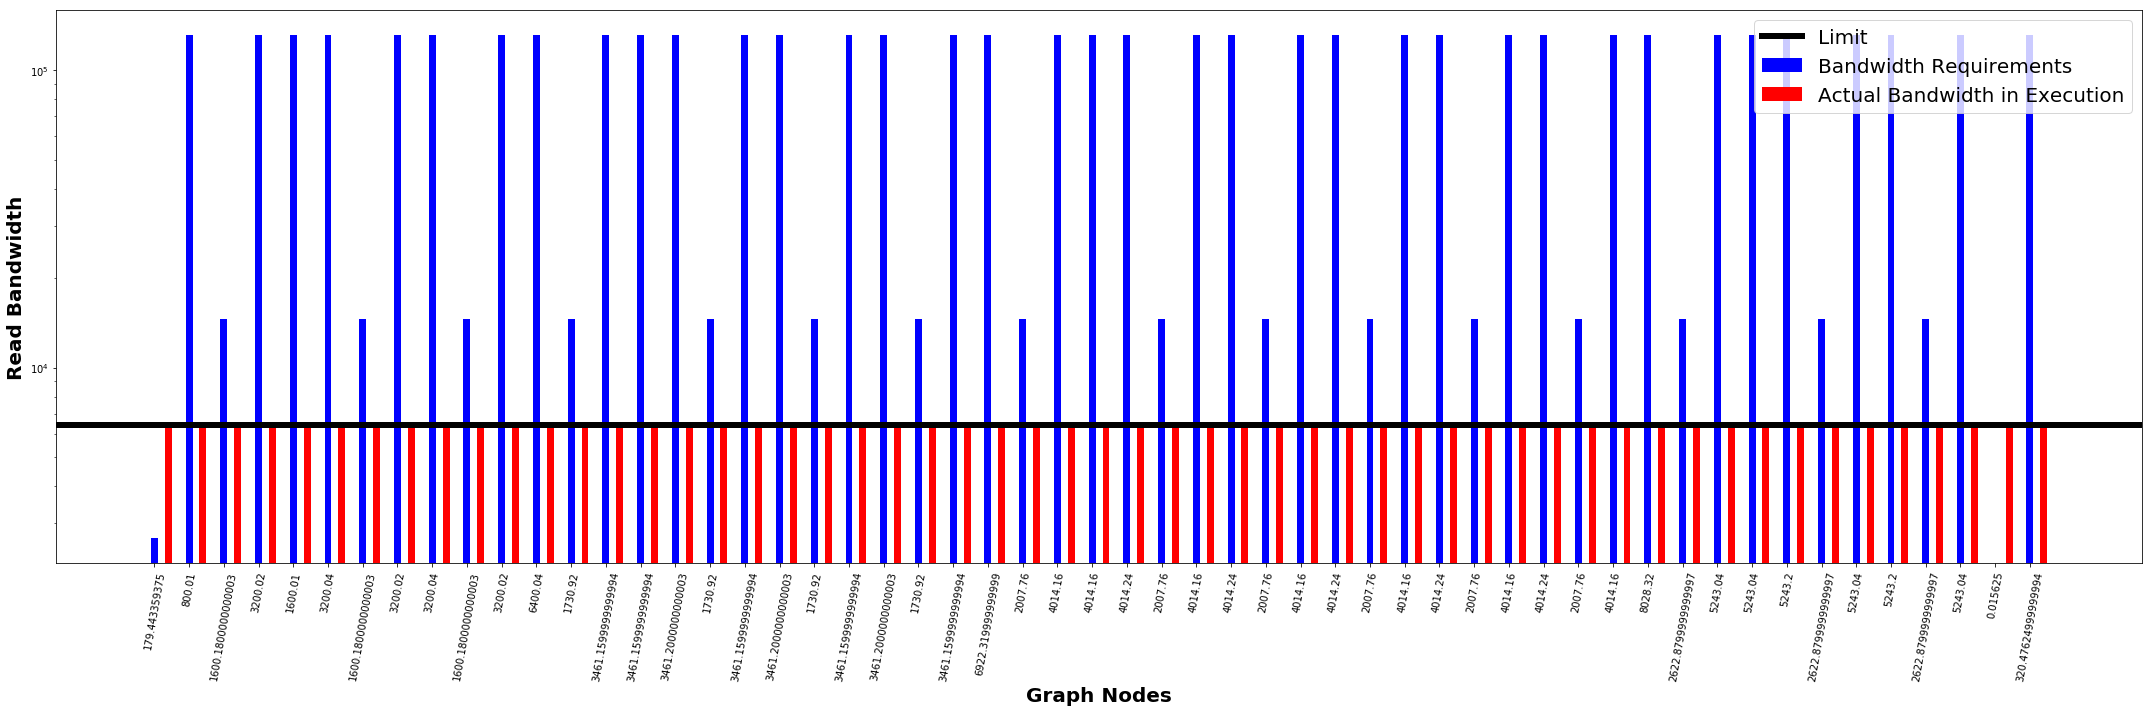

NameError: name 'macs' is not defined

In [15]:
runner([graph])

In [16]:
print(vgg11_graph.nodes)

[aten::_convolution, aten::_convolution, aten::_convolution, aten::_convolution, aten::_convolution, aten::_convolution, aten::_convolution, aten::_convolution, aten::adaptive_avg_pool2d, aten::addmm, aten::addmm, aten::addmm]


In [53]:
import numpy as np
import pandas as pd

d = pd.read_csv('plugins/cacti/bus_width.out')

d = d.drop(d.columns[[0,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]], axis=1)

d = d.drop(' Associativity',1)
d = d.drop(' Dynamic search energy (nJ)',1)

In [54]:
d

,Capacity (bytes),Number of banks,Output width (bits),Access time (ns),Random cycle time (ns),Dynamic read energy (nJ),Dynamic write energy (nJ),Standby leakage per bank(mW),Area (mm2)
0,2048,4,8,0.204697,0.133432,0.000774,0.000832,0.645661,0.007384
1,4096,4,8,0.224630,0.154180,0.001190,0.001103,1.154810,0.012947
2,32768,4,8,0.364274,0.239594,0.004907,0.003043,9.444110,0.095720
3,131072,4,8,0.672365,0.363393,0.010358,0.006168,34.431800,0.365163
4,262144,4,8,0.956541,0.363393,0.012486,0.008297,68.820000,0.739643
5,1048576,4,8,1.720920,0.363393,0.020601,0.016349,273.909000,2.892540
6,4194304,4,8,2.914920,0.430365,0.040569,0.032271,1085.910000,10.843700
7,8388608,4,8,3.959630,0.430365,0.056064,0.047766,2171.320000,21.655600
8,16777216,4,8,5.244400,0.430365,0.075337,0.067039,4342.210000,43.203600
9,33554432,4,8,6.980920,0.841165,0.115367,0.097924,7915.300000,82.795700


In [55]:
a= np.array(d)

np.savetxt('bus.csv',a, fmt='%.18e', delimiter=',')

# input = a[:,:3]

# output = a[:,3:]

In [ ]:
bar_graph("read_dummy.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)


In [43]:
print(input)

[[2.04800000e+03 1.00000000e+00 3.20000000e+01]
 [4.09600000e+03 1.00000000e+00 3.20000000e+01]
 [3.27680000e+04 1.00000000e+00 3.20000000e+01]
 [1.31072000e+05 1.00000000e+00 3.20000000e+01]
 [2.62144000e+05 1.00000000e+00 3.20000000e+01]
 [1.04857600e+06 1.00000000e+00 3.20000000e+01]
 [4.19430400e+06 1.00000000e+00 3.20000000e+01]
 [8.38860800e+06 1.00000000e+00 3.20000000e+01]
 [1.67772160e+07 1.00000000e+00 3.20000000e+01]
 [3.35544320e+07 1.00000000e+00 3.20000000e+01]
 [1.34217728e+08 1.00000000e+00 3.20000000e+01]
 [6.71088640e+07 1.00000000e+00 3.20000000e+01]
 [1.07374182e+09 1.00000000e+00 3.20000000e+01]
 [2.04800000e+03 1.00000000e+00 6.40000000e+01]
 [4.09600000e+03 1.00000000e+00 6.40000000e+01]
 [3.27680000e+04 1.00000000e+00 6.40000000e+01]
 [1.31072000e+05 1.00000000e+00 6.40000000e+01]
 [2.62144000e+05 1.00000000e+00 6.40000000e+01]
 [1.04857600e+06 1.00000000e+00 6.40000000e+01]
 [4.19430400e+06 1.00000000e+00 6.40000000e+01]
 [8.38860800e+06 1.00000000e+00 6.400000

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
base_dir = "figures/"
error_config = {"ecolor": "0.3"}
index = np.arange((len(var1)))
#     plt.axhline(y=var3, color="black", linestyle="-", label="Limit", linewidth=6)
ax.bar(
    index,
    var1,
    bar_width,
    color="blue",
    error_kw=error_config,
    label="",
)
# ax.bar(
#     index + 2 * bar_width,
#     var2,
#     bar_width,
#     color="red",
#     error_kw=error_config,
#     label="",
# )
ax.legend(fontsize=20)
plt.yscale("log")
ax.set_xticks(index)
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=80)
plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
plt.rc("ytick", labelsize=20)
ax.set_ylabel("Read Bandwidth", fontsize=20, fontweight="bold")
ax.set_xlabel("Graph Nodes", fontsize=20, fontweight="bold")
fig.tight_layout()
plt.savefig(base_dir + "sram.png", bbox_inches="tight")
plt.show()

name: diannao
    technology: 40nm
    
    
local:
    compute:
        name       : MACs
            class      : mac
            attributes :            
            instances       : 256
            meshX           : 16
            word-bits       : 16

    memory: 
        name       : DRAM
            class      : DRAM
            attributes :
            instances       : 1
            word-bits       : 16
  
        name       : OutputBuffer
            class      : SRAM
            attributes :
            entries         : 1024  # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        name       : InputBuffer
            class      : SRAM
            attributes :
            entries         : 1024 # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        name       : PsumRegFile
            class      : regfile
            attributes :
            entries         : 1
            instances       : 16
            meshX           : 16
            word-bits       : 16
            cluster-size    : 16
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
            
        name       : WeightBuffer
            class      : regfile
            attributes :
            entries         : 64
            instances       : 256
            meshX           : 16
            word-bits       : 16
            cluster-size    : 256
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
    noc:

